# Walk aligned raster

Take the recordings and behavior from a session, find all the tiems the mouse goes from stationary to moving, cut the recording around that and show a raster plot.

In [217]:
# imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from data.dbase.db_tables import Probe, Unit, Session, ValidatedSession, Recording, Tracking
from data.data_utils import convolve_with_gaussian

from fcutils.maths.signals import get_onset_offset
from fcutils.plot.figure import clean_axes, calc_nrows_ncols
from myterial import amber_darker, green_dark, grey_darker, blue_darker


save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")


# print all available recordings
print(*zip(*Recording().fetch("name", "recording_probe_configuration")), sep="\n")

('FC_210715_AAA1110750_r5_hairpin', 'longcolumn')
('FC_210716_AAA1110750_r6_hairpin', 'longcolumn')
('FC_210720_AAA1110750_hairpin', 'longcolumn')
('FC_210721_AAA1110750_hairpin', 'longcolumn')
('FC_210722_AAA1110750_hairpin', 'longcolumn')
('FC_211022_BAA110516_hairpin', 'longcolumn')
('FC_211027_BAA110516_hairpin', 'longcolumn')
('FC_211214_BAA110517_hairpin', 'b0')
('FC_220114_BAA110517_hairpin', 'b0')
('FC_220117_BAA110517_hairpin', 'b0')
('FC_220119_BAA110517_hairpin', 'b0')
('FC_220120_BAA110517_hairpin', 'b0')
('FC_210917_BAA1110279_hairpin', 'b0')
('FC_210820_BAA1110281_hairpin', 'longcolumn')
('FC_210829_BAA1110281_hairpin', 'longcolumn')
('FC_210830_BAA1110281_hairpin', 'longcolumn')
('FC_210831_BAA1110281_hairpin', 'longcolumn')
('FC_210901_BAA1110281_hairpin', 'longcolumn')
('FC_210906_BAA1110281_hairpin', 'b0')
('FC_210917_BAA1110281_hairpin', 'b0')


C:\ProgramData\Miniconda3\envs\dev\lib\site-packages\datajoint\connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


## load data

In [186]:
REC = "FC_210831_BAA1110281_hairpin"

metadata = pd.DataFrame(
    (Recording & f'name="{REC}"').fetch()
)

tracking = Tracking.get_session_tracking(REC, body_only=False)
print(tracking.columns)

units = pd.DataFrame(Unit * Unit.Spikes * Probe.RecordingSite & f'name="{REC}"')
units = units.sort_values("brain_region", inplace=False).reset_index()

Index(['mouse_id', 'name', 'bpname', 'orientation', 'angular_velocity',
       'speed', 'acceleration', 'theta', 'thetadot', 'thetadotdot', 'x', 'y',
       'bp_speed', 'moving', 'walking', 'turning_left', 'turning_right',
       'left_fl_moving', 'right_fl_moving', 'left_hl_moving',
       'right_hl_moving', 'segment', 'global_coord'],
      dtype='object')


## Get walking onsets

In [234]:
# get the speed of each limb (somehow its not in the database)
def get_speed(x, y):
    """
        Compute speed at each frame from XY coordinates
    """
    rawspeed = np.hstack([[0], np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2)]) * 60
    return convolve_with_gaussian(rawspeed, 9)

left_fl = tracking.loc[tracking.bpname == "left_fl"].iloc[0]
right_fl = tracking.loc[tracking.bpname == "right_fl"].iloc[0]
left_hl = tracking.loc[tracking.bpname == "left_hl"].iloc[0]
right_hl = tracking.loc[tracking.bpname == "right_hl"].iloc[0]
body = tracking.loc[tracking.bpname == "body"].iloc[0]

for limb in (left_fl, right_fl, left_hl, right_hl):
    limb.speed = get_speed(limb.x, limb.y)


the mouse is considered to be walking when at least two of the pasws body parts are moving with a high enough speed

In [274]:
def get_walking_from_paws(left_fl, right_fl, left_hl, right_hl, SPEED_TH):
    """
        "walking" is when the paws are moving
    """

    limbs_moving = {l.bpname: l.speed > SPEED_TH for l in (left_fl, right_fl, left_hl, right_hl)}

    walking = np.sum(
            np.vstack(list(limbs_moving.values())), axis=0
        )
    walking = walking >= 2  # at least 2 limbs moving
    walking = medfilt(walking.astype(float), 11)
    return walking

def get_walking_from_body(body, SPEED_TH):
    """
        "walking" is when the body is moving
    """
    walking = medfilt(body.speed, 11) > SPEED_TH
    # walking = medfilt(walking.astype(float), 11)
    return walking


def get_clean_walking_onsets(walking, MIN_WAKING_DURATION, MIN_PAUSE_DURATION):
    """
        Keep only locomotion onset when it lasts long enough and there's a pause before the previous one
    """
    onsets, offsets = get_onset_offset(walking, 0.5)
    print(f"Foun {len(onsets)} walking bouts ({len(offsets)} offsets)")


    walking_starts, walking_ends = [], []
    for onset in onsets:
        # get the last offset before this
        prev_offset = offsets[offsets < onset]
        if len(prev_offset) == 0:
            continue
        else:
            prev_offset = prev_offset[-1]

        # get the next offset after this
        next_offset = offsets[offsets > onset]
        if len(next_offset) == 0:
            continue
        else:
            next_offset = next_offset[0]


        # get pause and bout duration
        pause_duration = (onset - prev_offset) / 60
        bout_duration = (next_offset - onset) / 60

        # check conditions
        if pause_duration < MIN_PAUSE_DURATION or bout_duration < MIN_WAKING_DURATION:
            # print(f"Skipping bout at {onset}, duration {bout_duration} pause {pause_duration}")
            continue

        # keep onsets offests
        walking_starts.append(onset)
        walking_ends.append(next_offset)

    print(f'Found {len(walking_starts)} valid bouts')
    return walking_starts, walking_ends

get clean locomotion bouts: when the mouse walks for long enough and where there was a long enough pause before

Foun 867 walking bouts (866 offsets)
Found 111 valid bouts


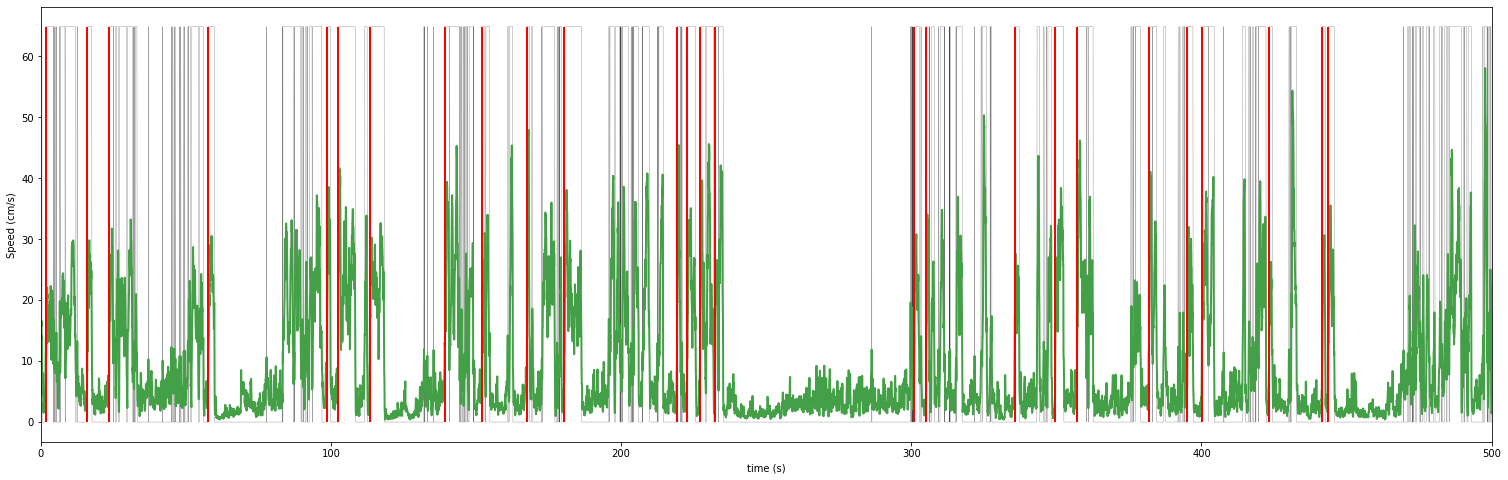

In [283]:
MIN_WAKING_DURATION = 1.0  # when the mouse walks < than this we ignore it (seconds)
MIN_PAUSE_DURATION = .5  # when the mouse pauses < before a walking bout than this we ignore it (seconds)
SPEED_TH = 10

walking = get_walking_from_body(body, SPEED_TH)
walking_starts, walking_ends = get_clean_walking_onsets(walking, MIN_WAKING_DURATION, MIN_PAUSE_DURATION)


# # turn timestamps into seconds
walking_starts = np.array(walking_starts) / 60
walking_ends = np.array(walking_ends) / 60



# plot speed and walking for the whole session
f, ax = plt.subplots(figsize=(26, 8))

tracking_time = np.arange(0,len(body.x+1)) / 60
speed = medfilt(body.speed, 11)

_ = ax.plot(tracking_time, walking * np.max(speed), lw=.25, alpha=1, color=grey_darker)
_ = ax.plot(tracking_time, speed, lw=2, color=green_dark)

ax.vlines(walking_starts, 0, np.max(speed), color="red", lw=2, alpha=1)

_ = ax.set(ylabel="Speed (cm/s)", xlabel="time (s)",
    xlim=[0, 500]
)

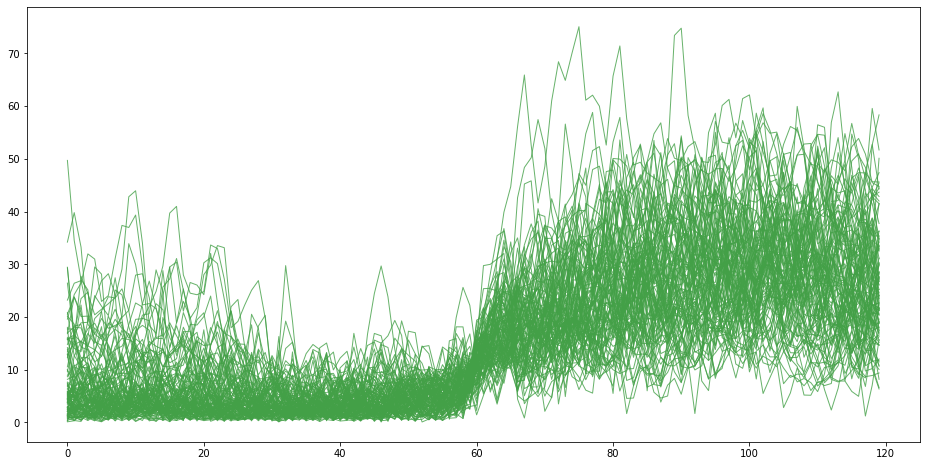

In [285]:
# plot speed trace aligned to walking starts
f, ax = plt.subplots(figsize=(16, 8))
for bout in walking_starts:
    bout = int(bout * 60)
    _ = ax.plot(body.speed[bout-60:bout+60], lw=1, alpha=.8, color=green_dark)

plot speed at walking onsets

## Raster plot
for each unit, take the spikes around the time of bout onset and make a rater plot.

In [193]:
def raster(ax, unit, timestamps, t_before=1, t_after=1, dt=.1):
    """
        Plot a unit spikes aligned to timestamps (in seconds).
        it also adds a firing rate visualization
    """
    ax.plot([0, 0], [0,1], lw=3, color="k", alpha=.3)
    n = len(timestamps)
    h = 1/n

    spikes = unit.spikes_ms / 1000
    perievent_spikes = []
    X, Y = [], []
    for i,t in enumerate(timestamps):
        trial_spikes = spikes[(spikes > t-t_before) & (spikes < t+t_after)]
        y = np.zeros_like(trial_spikes) + (i * h)

        Y.extend(y)
        perievent_spikes.extend(trial_spikes-t)
    ax.scatter(perievent_spikes, Y, s=4, color=unit.color, alpha=1, marker=7)

    # add horizontal cax to axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='30%', pad=0.05)
    cax.axvline(0, lw=3, color="k", alpha=.3, zorder=-1)
    cax.hist(perievent_spikes, bins=np.arange(-t_before, t_after+dt, step=dt), color=unit.color, alpha=1)

    ax.set(
        xlabel="time (s)",
        ylabel="trial",
        yticks=np.arange(0, 1, 5/n),
        yticklabels=(np.arange(0, 1, 5/n) * n).astype(int),
        xlim=[-t_before, t_after],
        
    )
    cax.set(ylabel="Spike counts", xticks=[], title = f"Unit {unit.unit_id} - {unit.brain_region}", xlim=[-t_before, t_after],)
    return ax, cax


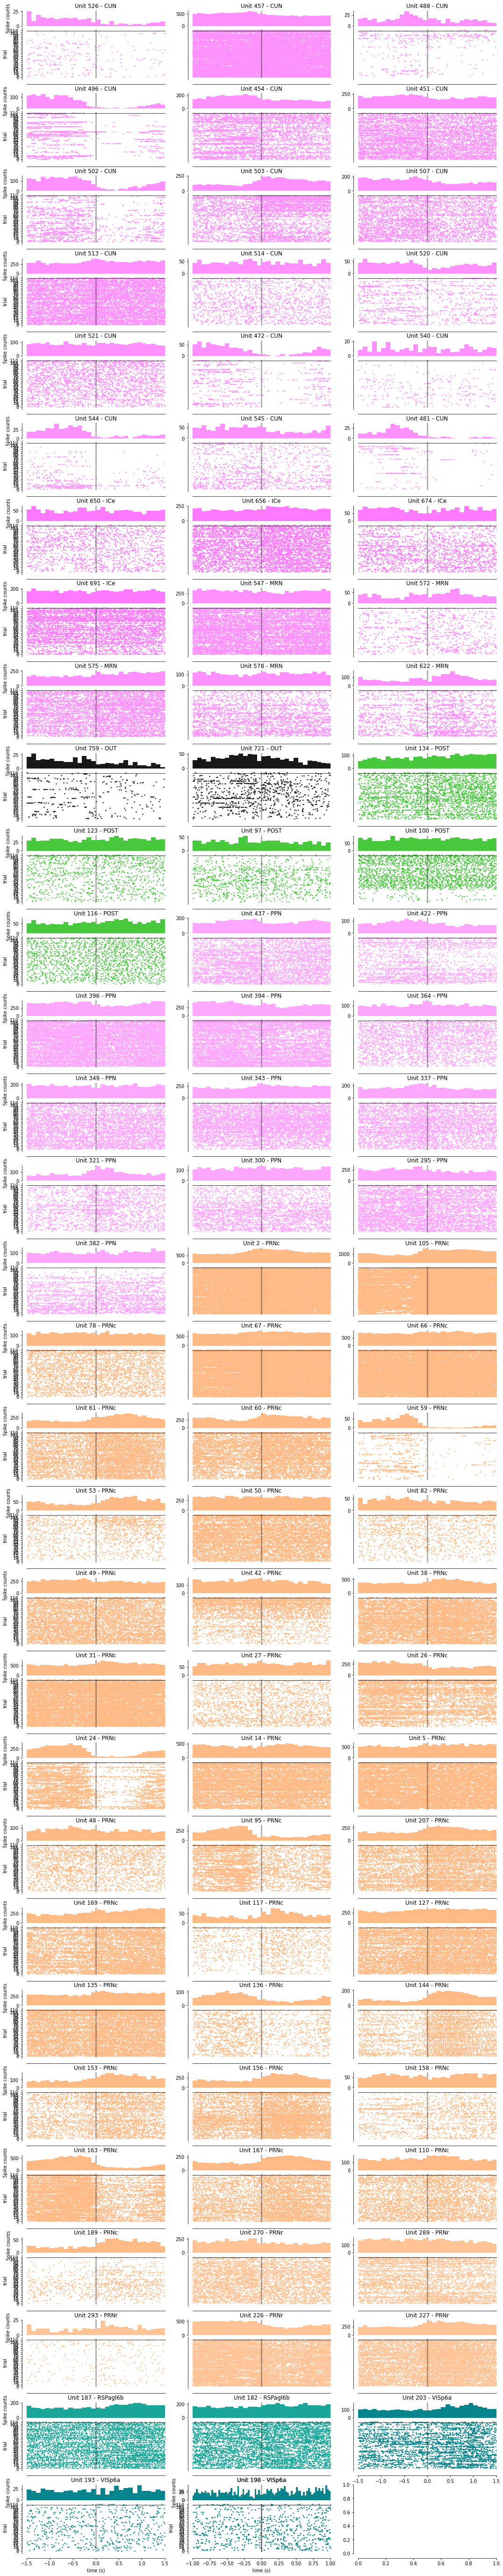

In [286]:


f, axes = plt.subplots(np.ceil(len(units)/3).astype(int), 3, figsize=(18, 100))
# f.suptitle(f"{REC} - locomotion onset")

for (i, unit), ax in zip(units.iterrows(), axes.flatten()):
    ax, cax = raster(ax, unit, walking_starts, t_before=1.5, t_after=1.5, dt=.1)

    if i < len(units)-3:
        ax.set(xticks=[], xlabel=None)

    if i % 3 != 0:
        ax.set(yticks=[], ylabel=None)
        cax.set(ylabel=None)


clean_axes(f)
f.savefig(save_folder / f"{REC}_units_walkonset_aligned_raster.png", dpi=100, bbox_inches="tight")